# Bayesian Optimization: Uncertanity Quantification

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import pystorms
import GPyOpt
from pyswmm_lite import environment

In [18]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

### Experiment setup

#### Network Topology
**Why this particular network?**
1. Numerical Calculation: This enables to compute all the possible configurations of control actions and numerically estimate the uncertanity, given a network and stormevent. 
2. Representation of Uncertanity: We cannot effectively convey uncertanity when we have more than 2 dimentions (in this case that is 2 basins). Figuring out how uncertanity works in larger dimension is still a challenging problem. 
3. Configuration: Why parallel ? why not series ?

#### Synthetic Inflows
Flows in a stormwater network has three fundamental components:
* How big is a rainevent? (amplitude)
* When will the peak be? (time)
* How wide is the dispersion? (spread)
    
This makes sense in the case of a single event. But how will perform in the case of multiple events. But we are using this validating our approach rather than saying these are things you have to do. Hence it might be ok to ignore the case with multiple stormevents.

In [23]:
def SynthNetwork(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions[0])
        env._setValvePosition("1", actions[1])

        env.sim._model.setNodeInflow("P1", flows["P1"][time])
        env.sim._model.setNodeInflow("P2", flows["P2"][time])

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"])

In [24]:
def GaussianSignal(x, amplitude, timetopeak, dispersion):
    flows = amplitude * (1.0/(dispersion*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-timetopeak)/dispersion)**2)
    return flows

In [25]:
x = np.linspace(-10.0, 10.0, 100)
flows = GaussianSignal(x, 1.0, -2.0, 2.0)

Text(0.5, 0, 'Duration of Signal')

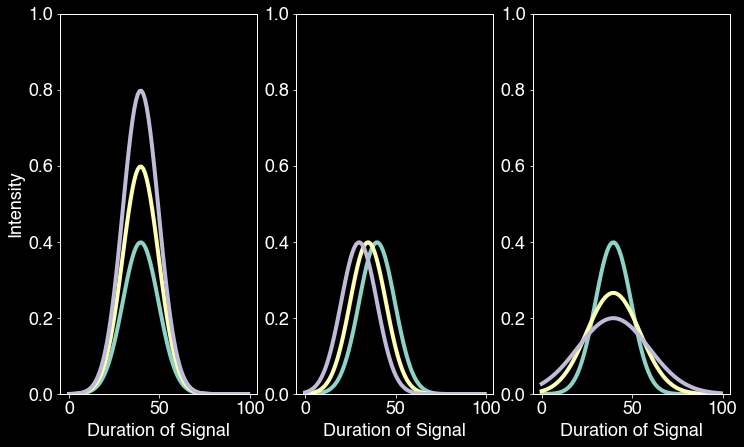

In [26]:
plt.subplot(1,3,1)
for amp in [2.0, 3.0, 4.0]:
    flows = GaussianSignal(x, amp, -2.0, 2.0)
    plt.plot(flows)
    plt.ylim([0.0, 1.0])
plt.ylabel("Intensity")
plt.xlabel("Duration of Signal")

plt.subplot(1,3,2)
for srt in [2.0, 3.0, 4.0]:
    flows = GaussianSignal(x, 2.0, -srt, 2.0)
    plt.plot(flows)
    plt.ylim([0.0, 1.0])
plt.xlabel("Duration of Signal")

plt.subplot(1,3,3)
for disp in [2.0, 3.0, 4.0]:
    flows = GaussianSignal(x, 2.0, -2.0, disp)
    plt.plot(flows)
    plt.ylim([0.0, 1.0])
plt.xlabel("Duration of Signal")

When we are working with only a single basin and one rainevent. Does it really matter, when the storm hits. No, because the given that we only have one event controller is going to look at the whole respose, time to peak does not matter. 

Hence, we should just focus on dispersion and amplitude.

# Single Basin: Amplitude

Before, we simulate 2 bains. Let us first start simulating one basin with just amplitude variance.

In [27]:
def SynthNetwork1(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)

    data = {}
    data["outflow"] = []
    data["overflow"] = []
    
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)

        env.sim._model.setNodeInflow("P1", flows["P1"][time])
        env.sim._model.setNodeInflow("P2", 0.0)

        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))

        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"])